In [1]:
import dask.dataframe as dd
import numpy as np
import os
import pandas as pd

#### Thay đổi hiển thị ####
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.set_option('display.max_row', None)
pd.set_option('display.max_columns', None)
#### Change display ####

input_file = ["/mnt/c/Users/hoang/FileCSV_DACN_2025/parquet_shuffled_IoT23", "C:\\Users\\hoang\\FileCSV_DACN_2025\\parquet_shuffled_IoT23"]

if os.name == 'nt':
    input_file = input_file[1]
else:
    input_file = input_file[0]

df = dd.read_parquet(input_file)
df = df.drop(columns=['label'])
print(df.dtypes)


id.orig_h         float32
id.orig_p         float32
id.resp_h         float32
id.resp_p         float32
duration          float32
orig_bytes        float32
resp_bytes        float32
conn_state        float32
missed_bytes      float32
history           float32
orig_pkts         float32
orig_ip_bytes     float32
resp_pkts         float32
resp_ip_bytes     float32
detailed-label      int32
proto_icmp          int32
proto_tcp           int32
proto_udp           int32
service_dhcp        int32
service_dns         int32
service_http        int32
service_irc         int32
service_ssh         int32
service_ssl         int32
dtype: object


In [2]:
label_counts = df['detailed-label'].value_counts().compute()

In [3]:
print((label_counts))

detailed-label
1    60938340
0    30771095
Name: count, dtype: int64


detailed-label
1    60938340
0    30771095
Name: count, dtype: int64


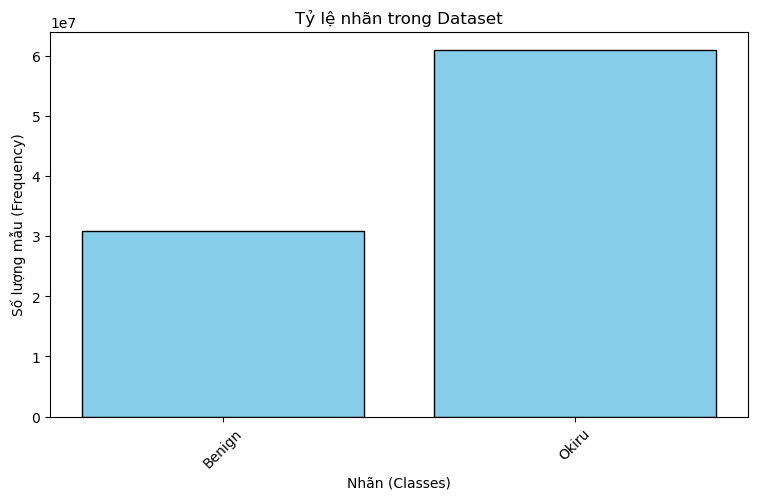

In [4]:

import matplotlib.pyplot as plt
ordered_labels = [0, 1]
ordered_counts = [label_counts.get(label, 0) for label in ordered_labels] 
print(label_counts)

labels = ["Benign", "Okiru"]
# Vẽ biểu đồ cột
plt.figure(figsize=(9, 5))
plt.bar(labels, ordered_counts, color='skyblue', edgecolor='black')
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng mẫu (Frequency)")
plt.title("Tỷ lệ nhãn trong Dataset")
plt.xticks(range(len(labels)) ,labels, rotation =45)
plt.show()

In [ ]:


import numpy as np

temp_df = df.head(500000)
labels = temp_df['detailed-label'].values

change_points = np.where(labels[1:] != labels[:-1])[0] + 1
change_points = np.concatenate(([0], change_points, [len(labels)]))
lengths = np.diff(change_points)

max_consecutive = lengths.max()
print("Chuỗi mẫu liên tiếp dài nhất trong 500,000 mẫu đầu là:", max_consecutive)


: 

In [2]:
df = df[df['detailed-label'].isin(['Okiru', 'PartOfAHorizontalPortScan', '0'])]

label_map = {
    '0': 0,
    'PartOfAHorizontalPortScan': 1,
    'Okiru': 2
}

df['detailed-label'] = df['detailed-label'].map(label_map).astype('int32')

/home/hoangvn/miniconda3/miniconda3/envs/doan/lib/python3.9/site-packages/dask_expr/_collection.py:4190: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('detailed-label', 'float64'))

  warnings.warn(meta_warning(meta))


In [13]:
print(len(df.dtypes))

24


# Generator + Train

In [4]:
import numpy as np
import pandas as pd
import dask.dataframe as dk
import tensorflow as tf 
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from datetime import datetime, timedelta
from tensorflow import keras

ratio_test_all = 0.2

from dask_ml.model_selection import train_test_split 
# Bước 1: Tách 80% train, 20% còn lại (val + test)
train_df, val_test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.75, random_state=42)

c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask_ml\model_selection\_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [5]:
################################ BATCH SIZE ########################################
batchSize = 512

features_len = len(df.columns)-1
print("Feature Len: ",features_len)

def dask_to_tf_dataset(dask_df, num_classes): 
    def generator():
        for batch in dask_df.to_delayed():
            batch=batch.compute()  
            if batch.empty:
                continue

            X = batch.drop(columns='detailed-label').values.astype(np.float32)
            y = batch['detailed-label'].values.astype(np.int32)
            y_onehot = to_categorical(y, num_classes=num_classes) if num_classes >1 else y

            # for i in range(0, len(X), batchSize):
            #     yield X[i:i+batchSize], y_onehot[i:i+batchSize]
            num_splits = max(1, len(X) // batchSize)  # Đảm bảo không chia nhỏ quá mức
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y_onehot, num_splits)

            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch
            
    output_signature = ( 
        tf.TensorSpec(shape=(None, features_len), dtype=tf.float32), 
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.int32),
    ) if num_classes>1 else ( 
        tf.TensorSpec(shape=(None, features_len), dtype=tf.float32), 
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
    )
    
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

Feature Len:  23


In [6]:
############################ NUM CLASSES#########################
value_count = len(df['detailed-label'].value_counts().compute())
num_classes = 1 if  value_count<=2  else value_count

########################### GENERATOR ############################
train_gen = dask_to_tf_dataset(train_df, num_classes).repeat()
val_gen = dask_to_tf_dataset(val_df, num_classes).repeat()
test_gen = dask_to_tf_dataset(test_df, num_classes)

In [8]:
import math
n_samples = np.ceil(train_df.shape[0])
steps_per_epoch = int(n_samples / (batchSize))
validation_steps = int(steps_per_epoch / (16))
print("Steps/Epoch: ", steps_per_epoch)

Steps/Epoch:  143314


In [ ]:
########### Enable XLA ###############
tf.config.optimizer.set_jit(True)

steps_per_epoch = 143314 // 10
validation_steps= (steps_per_epoch)//16
    
########### Nếu không dùng XLA ###########
# import os
# os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"

# shape
features, labels = next(iter(train_gen))
input_shape = (features.shape[1], 1)
output_shape = labels.shape[1] if num_classes > 1 else 1
print(f"Input Shape: {input_shape} \n Output Shape: {output_shape}")

start_time = datetime.now()

loss_func = 'categorical_crossentropy' if num_classes > 1 else 'binary_crossentropy'
activation_func = 'softmax' if num_classes >1 else 'sigmoid'
print(f"Num classe: {num_classes}\nLoss Fucntion: {loss_func}\nActivation Function: {activation_func}")
model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv1D(filters=32, kernel_size=7, padding="same", activation="relu", kernel_regularizer=l2(0.05)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.7),
    layers.Flatten(), 
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.05)),
    layers.Dense(output_shape, activation= activation_func)
])
adam_optimizer = optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=adam_optimizer, loss=loss_func, metrics=['accuracy'])
model.summary()

from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
csv_logger = CSVLogger("Centralized_Log/"+ datetime.now().strftime("Month%mDay%d__%Hh%Mp")+".csv" , append=True)

model_path =  "Centralized_Model/cnn_model_" + datetime.now().strftime("Month%mDay%d__%Hh%Mp")
print("Model Path: ", model_path)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose =1),
    ModelCheckpoint(model_path+"_best.keras", monitor='val_loss', save_best_only=True, verbose=1),
    csv_logger
]
model.fit(train_gen, epochs=16, validation_data=val_gen, validation_steps=validation_steps, steps_per_epoch=steps_per_epoch, verbose = 1, callbacks=callbacks)
end_time = datetime.now()
simulated_time = end_time - start_time
# Lưu mô hình
model.save(model_path+".keras")
print(f"Simulated time: {simulated_time}")

Input Shape: (23, 1) 
 Output Shape: 1
Num classe: 1
Loss Fucntion: binary_crossentropy
Activation Function: sigmoid


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 23, 32)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 23, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        22,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,041 (90.00 KB)

 Trainable params: 22,977 (89.75 KB)

 Non-trainable params: 64 (256.00 B)

Model Path:  Centralized_Model/cnn_model_Month05Day30__17h29p
Epoch 1/16
14327/14331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6105 - loss: 4.2832
Epoch 1: val_loss improved from inf to 0.89236, saving model to Centralized_Model/cnn_model_Month05Day30__17h29p_best.keras
14331/14331 ━━━━━━━━━━━━━━━━━━━━ 86s 6ms/step - accuracy: 0.6106 - loss: 4.2826 - val_accuracy: 0.9811 - val_loss: 0.8924
Epoch 2/16
14327/14331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9137 - loss: 0.7773
Epoch 2: val_loss improved from 0.89236 to 0.35217, saving model to Centralized_Model/cnn_model_Month05Day30__17h29p_best.keras
14331/14331 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.9137 - loss: 0.7772 - val_accuracy: 0.9818 - val_loss: 0.3522
Epoch 3/16
14323/14331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9692 - loss: 0.3544
Epoch 3: val_loss improved from 0.35217 to 0.20858, saving model to Centralized_Model/cnn_model_Month05Day30__17h29p_best.keras
14331/14331 ━━━━━━━━━━━━━━━━━━━━ 86s 6ms/ste

In [15]:
 # Đánh giá độ chính xác
test_steps = validation_steps*3 # validate 5% evaluate steps 15%
loss, accuracy = model.evaluate(test_gen, steps=test_steps)

history1 = {'acc': accuracy, 'loss': loss}
eval_save = model_path + "_Eval.csv"
pd.DataFrame([history1]).to_csv(eval_save, index=False, mode='w')

2685/2685 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9994 - loss: 0.0264


# Pre, Re, F1

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
model_path = "Centralized_Model/cnn_model_Month05Day30__17h29p_best.keras"
model = load_model(model_path)

test_steps = validation_steps*3 # 5% validation và 15% test
print(test_steps)

y_true_all = []
y_pred_all = []

for X_batch, y_batch in test_gen.take(test_steps):
    y_true_all.extend(y_batch.numpy().flatten())

    y_pred_prob = model.predict(X_batch, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_pred_all.extend(y_pred)

# Tính metric
precision = precision_score(y_true_all, y_pred_all, average='binary')
recall = recall_score(y_true_all, y_pred_all, average='binary')
f1 = f1_score(y_true_all, y_pred_all, average='binary')

# print("Precision: ", precision)
# print("Recall: ", recall)
# print("F1-Score: ", f1)

# param_names = ['Precision', 'Recall', 'F1-Score']
# array = [precision, recall, f1]

# x = np.arange(len(param_names))
# width = 0.2  # Độ rộng của mỗi cột
# plt.figure(figsize=(8, 5))
# plt.bar(param_names, array, color=['blue', 'green', 'red'])

# # Cấu hình trục và nhãn
# plt.ylabel("Score")
# plt.title("Precision, Recall, and F1-Score")
# plt.ylim(0, 1)  # Giá trị từ 0 đến 1
# plt.grid(axis="y", linestyle="--", alpha=0.7)

# # Hiển thị biểu đồ
# plt.show()


2685
   Metric    Score
Precision 0.999102
   Recall 1.000000
 F1-Score 0.999551


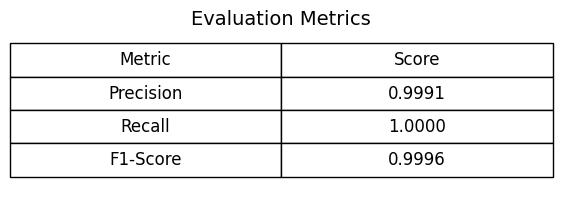

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 2))
ax.axis('off')  # Ẩn trục

# Dữ liệu bảng
table_data = [
    ["Metric", "Score"],
    ["Precision", f"{precision:.4f}"],
    ["Recall", f"{recall:.4f}"],
    ["F1-Score", f"{f1:.4f}"]
]

# Tạo bảng
table = ax.table(cellText=table_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.4, 2)

plt.title("Evaluation Metrics", fontsize=14)
plt.show()

# Confusion matrix

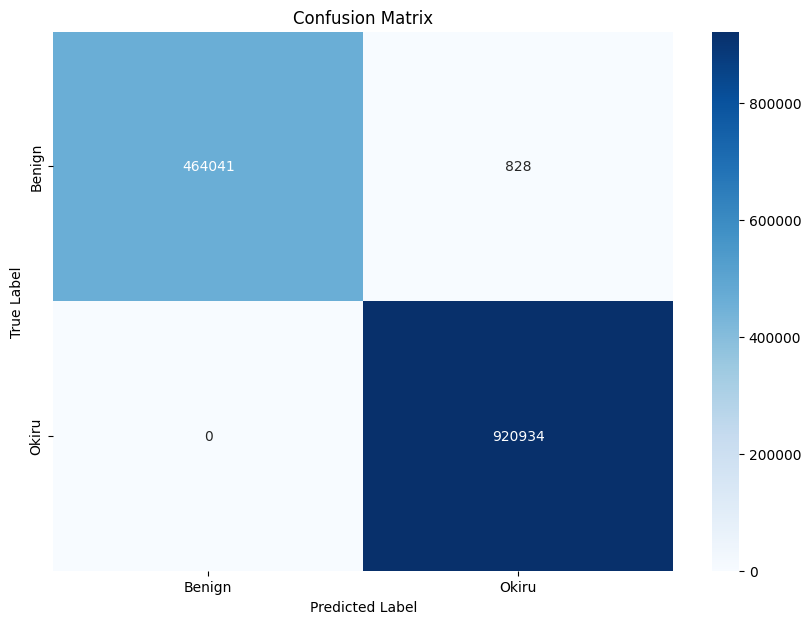

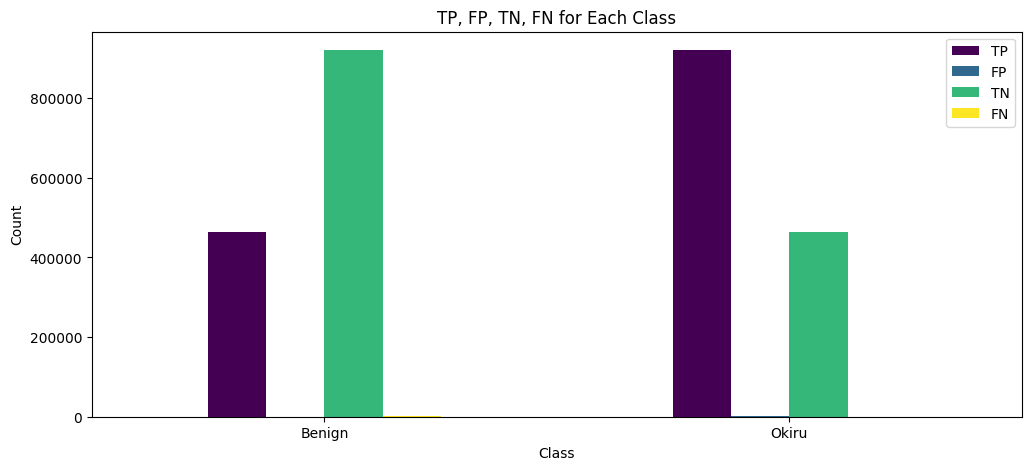

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_true_all, y_pred_all)
attack_types =['Benign', 'Okiru']
# Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

metrics = []
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])
# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class")
plt.xticks(rotation=0)
plt.legend(["TP", "FP", "TN", "FN"])
plt.show()

# Acc, Loss Graph

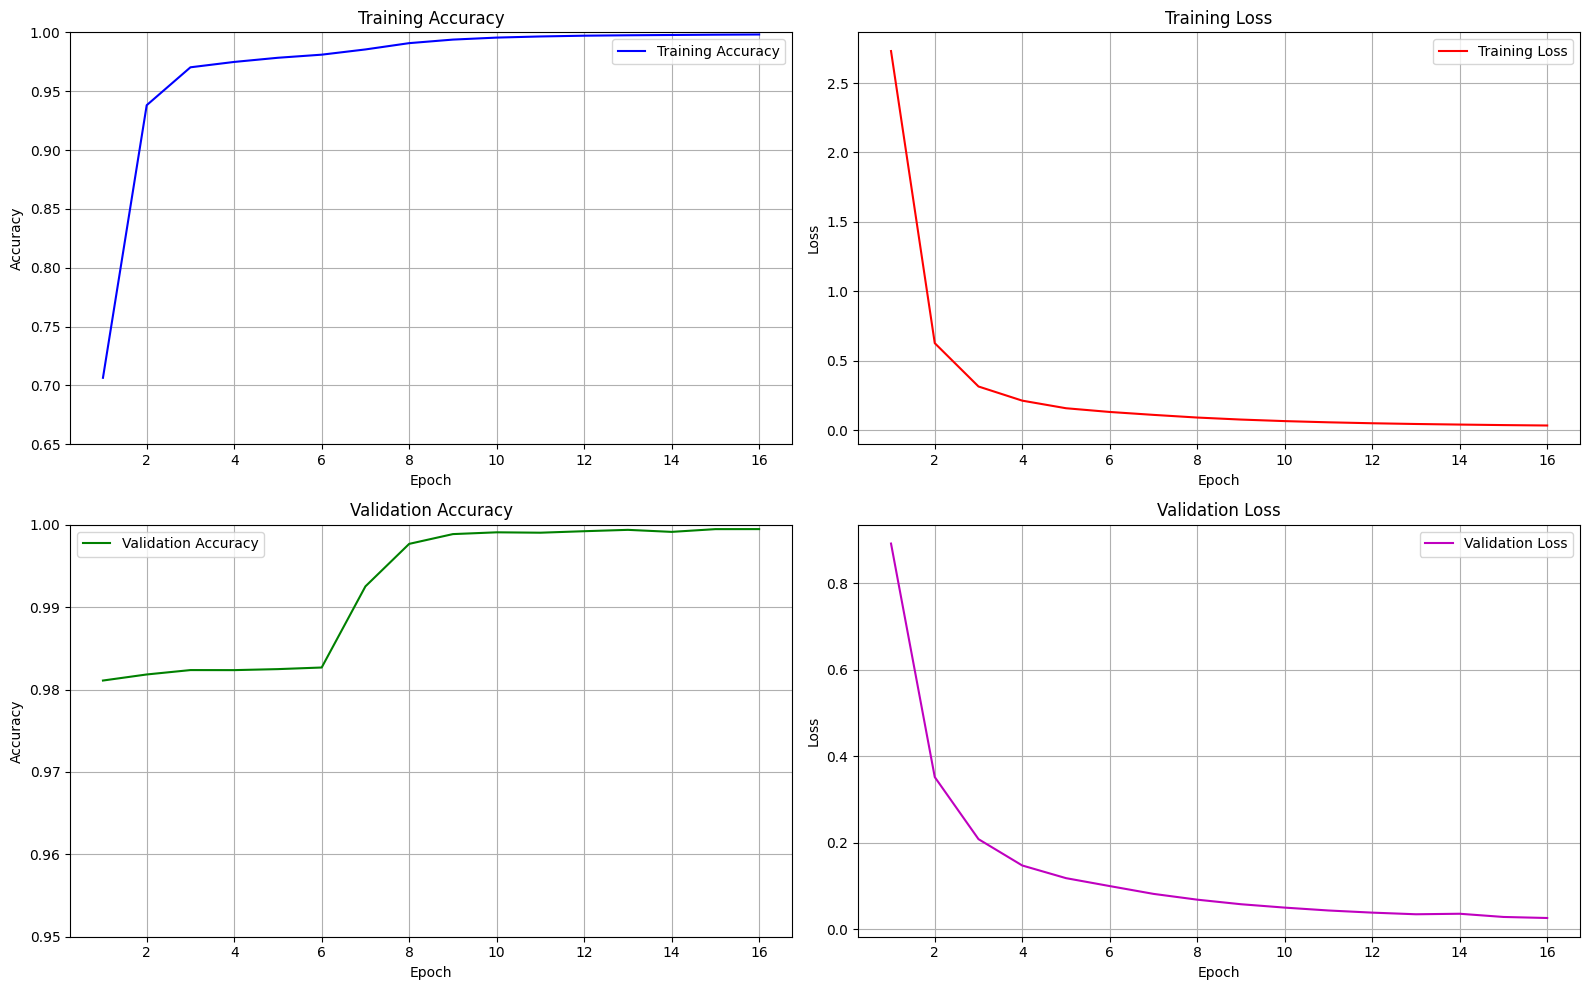

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc log từ file CSV
log_name = ["/mnt/c/Users/hoang/D/Code/CoCheMalware/Centralized_Log/Month05Day30__17h29p.csv", \
    "C:/Users/hoang/D/Code/CoCheMalware/Centralized Learning/Centralized_Log/Month05Day30__17h29p.csv"]
log_name = log_name[1] if os.name=='nt' else log_name[0]

log_df = pd.read_csv(log_name) 
epochs = range(1, len(log_df)+1)

plt.figure(figsize=(16, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, log_df['accuracy'], 'b-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.ylim(0.65, 1.0)

# Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, log_df['loss'], 'r-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, log_df['val_accuracy'], 'g-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.ylim(0.95, 1.0)

# Validation Loss
plt.subplot(2, 2, 4)
plt.plot(epochs, log_df['val_loss'], 'm-', label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()